# Load dependencies

In [180]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.linear_model import ElasticNet

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

# Import training data and check out info

In [181]:
train = pd.read_csv('../data/train.csv')
train.set_index(train['Id'])
train.drop('Id', axis=1, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

# Exploratory Data Analysis

- Create Total SF.
- Plot scatterplots of main features: Total SF, TotRmsAbvGrd, YearBuilt, LotArea, OverallQual
- Remove outliers.
- Check for highly skewed features.
- Check that there are features with no variation.

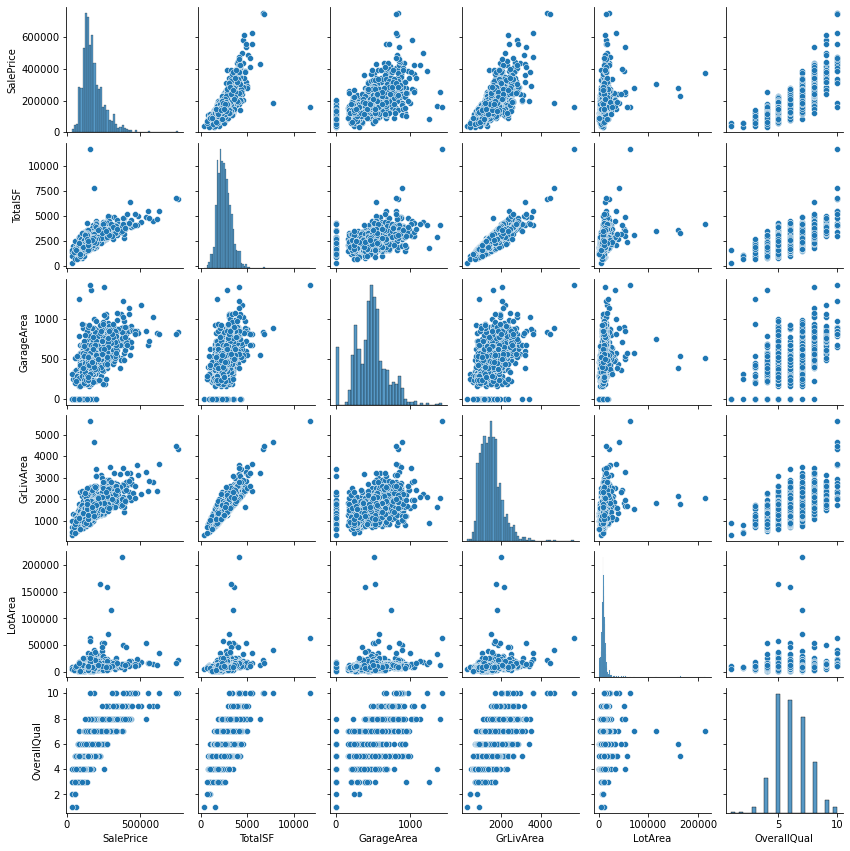

In [182]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
sns.pairplot(data=train[['SalePrice',
                         'TotalSF',
                         'GarageArea',
                         'GrLivArea',
                         'LotArea',
                         'OverallQual']], height=2)

Drop outliers and plot again

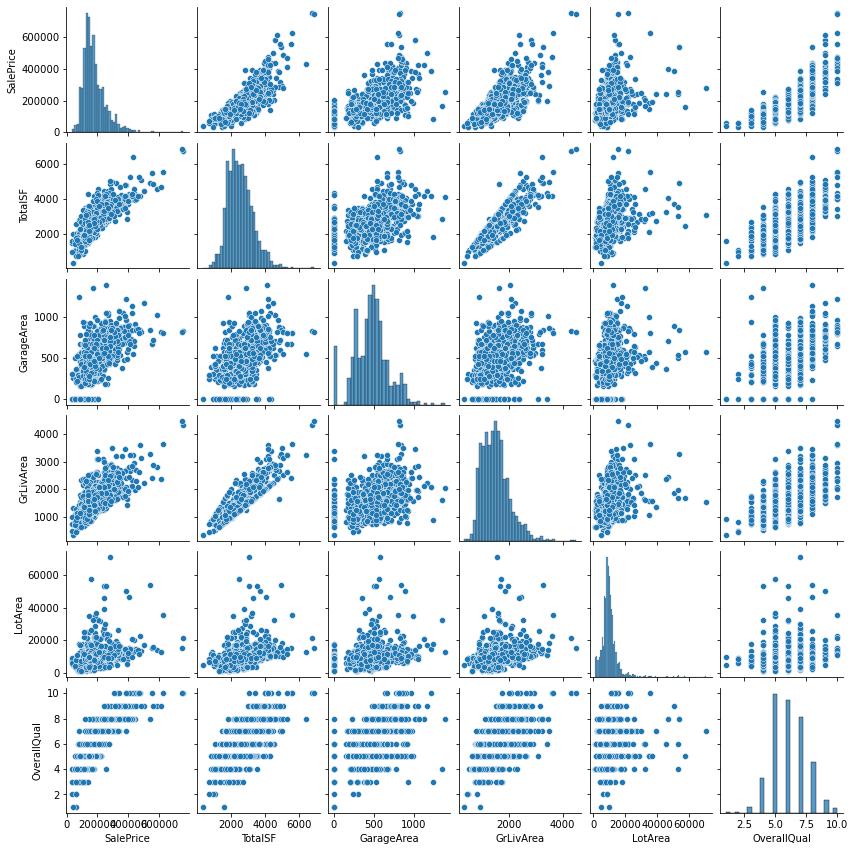

In [183]:
train.drop(train.index[train.TotalSF>7500],axis=0, inplace=True)
train.drop(train.index[train.LotArea>10e4],axis=0, inplace=True)

sns.pairplot(data=train[['SalePrice',
                         'TotalSF',
                         'GarageArea',
                         'GrLivArea',
                         'LotArea',
                         'OverallQual']], height=2)

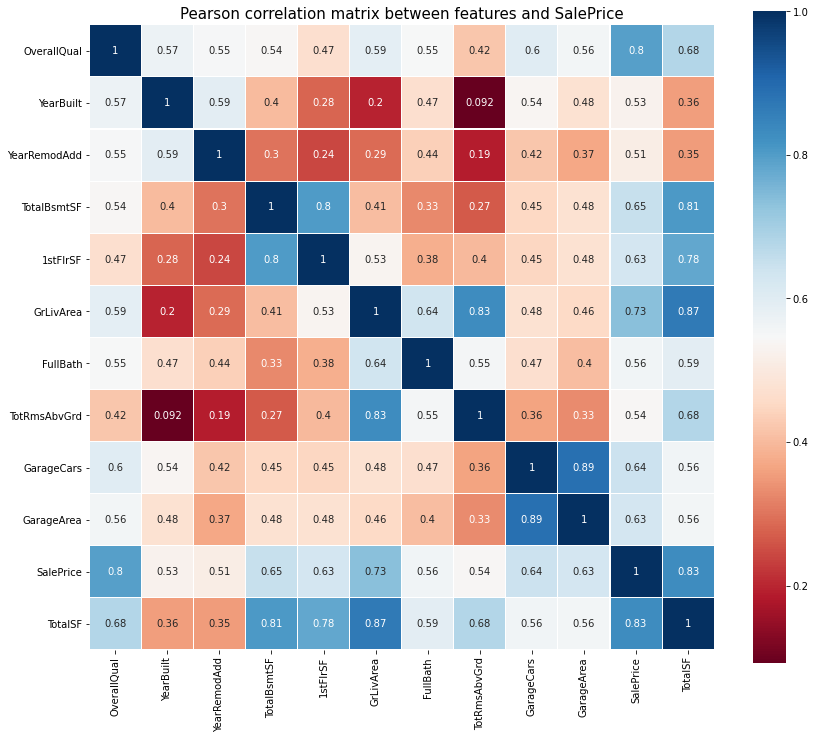

In [184]:
corr_train = train.corr()
highest_corr_features = corr_train.index[abs(corr_train['SalePrice']) > 0.5]

plt.figure(figsize=(14,12))
plt.title('Pearson correlation matrix between features and SalePrice', y=1, size=15)
sns.heatmap(train[highest_corr_features].corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True,
            cmap='RdBu',
            linecolor='white',
            annot=True)
plt.show()

In [185]:
# Check that there are no features with no variation
assert len(train.drop('SalePrice', axis=1).var()[lambda x: abs(x)<0.0001]) == 0

# Feature Engineering

Impute missing values
- Numerical features: use sample median
- Ordinal features: use sample mode
- Non-ordinal categorical features: use sample mode

Encode categorical values
- Ordinal features: use ordinal encoder
- Non-ordinal categorical features: use target encoding

In [186]:
cols_missing_value = train.columns[train.isna().sum()>0].values
cols_missing_value
train[cols_missing_value].info()

'''
Impute missing numerical features using median
'''
missing_num_att = train[cols_missing_value].select_dtypes(exclude='object').columns
for att in missing_num_att:
    train[att].fillna(train[att].median(), inplace=True)
    
'''
Impute missing ordinal/nonordinal features using mode
'''  
missing_cat_att = train[cols_missing_value].select_dtypes(include='object').columns
for att in missing_cat_att:
    train[att].fillna(train[att].mode()[0], inplace=True)
    
train[cols_missing_value].isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1198 non-null   float64
 1   Alley         91 non-null     object 
 2   MasVnrType    1446 non-null   object 
 3   MasVnrArea    1446 non-null   float64
 4   BsmtQual      1417 non-null   object 
 5   BsmtCond      1417 non-null   object 
 6   BsmtExposure  1416 non-null   object 
 7   BsmtFinType1  1417 non-null   object 
 8   BsmtFinType2  1416 non-null   object 
 9   Electrical    1453 non-null   object 
 10  FireplaceQu   764 non-null    object 
 11  GarageType    1373 non-null   object 
 12  GarageYrBlt   1373 non-null   float64
 13  GarageFinish  1373 non-null   object 
 14  GarageQual    1373 non-null   object 
 15  GarageCond    1373 non-null   object 
 16  PoolQC        6 non-null      object 
 17  Fence         281 non-null    object 
 18  MiscFeature   52 non-null   

LotFrontage     0
Alley           0
MasVnrType      0
MasVnrArea      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

In [187]:
num_att = ['LotFrontage','LotArea','OverallQual',
           'OverallCond','YearBuilt','YearRemodAdd',
           'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
           'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
           'GrLivArea','BsmtFullBath','BsmtHalfBath',
           'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
           'TotRmsAbvGrd','Fireplaces','GarageYrBlt',
           'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
           'EnclosedPorch','3SsnPorch','ScreenPorch',
           'PoolArea','MiscVal','MoSold','YrSold', 'TotalSF']

ordinal_att = ['LotShape', 'Utilities', 'LandSlope',
               'ExterQual','ExterCond','BsmtQual',
               'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
               'BsmtFinType2', 'HeatingQC','CentralAir',
               'KitchenQual','Functional','FireplaceQu',
               'GarageFinish', 'GarageQual', 'GarageCond',
               'PavedDrive','PoolQC','Fence']

nonordinal_att = ['MSZoning','Street','Alley',
                  'LandContour','LotConfig','Neighborhood',
                  'BldgType','HouseStyle','RoofStyle',
                  'RoofMatl','MasVnrType','Foundation',
                  'Heating','Electrical','GarageType',
                  'MiscFeature','SaleType','SaleCondition',
                  'Condition1','Condition2','Exterior1st','Exterior2nd']

# Further Cleaning
- Aggregate some nonordinal categories to ensure that there are sufficient observations for target encoding.
- Drop features where the largest category of the feature encompasses at least 90% of data.

In [188]:
drop_col = list()
for col in nonordinal_att:
    
    unique_values = len(train[col].unique())
    largest_cat = train[col].value_counts(normalize=True).max()
    
    if largest_cat >=0.90:
            drop_col.append(col)
    else:
        
        '''
        First combine categories that have less than 30 observations.
        Then remove remaining observations that are in categories with fewer than 30 observations.
        '''
        map_dict = train[col].value_counts()[lambda x : x < 30].to_dict()
        
        for key in map_dict.keys():
            train[col].replace(key, 'Not Enough Observations', inplace = True)
                        
# New nonordinal list
print(f'Drop List: {drop_col}')
train.drop(drop_col, axis=1, inplace=True)
nonordinal_att = list(set(nonordinal_att) - set(drop_col))

Drop List: ['Street', 'Alley', 'LandContour', 'RoofMatl', 'Heating', 'Electrical', 'MiscFeature', 'Condition2']


In [189]:
# Create feature list
features = num_att + ordinal_att + nonordinal_att

# Check all features are accounted for
assert len(set(features) - set(train.drop('SalePrice', axis=1).columns)) == 0

In [190]:
def target_encoder(df, att):
    '''
    Target encoding:
    replace categorical values with mean 
    sale price by category
    '''
    att = att + ['SalePrice']
    df_copy = df[att].copy()
    
    for col in att:
        if col != 'SalePrice':
            impute_dict = df_copy.groupby(col).agg({'SalePrice':'mean'}).to_dict()
            df_copy[col] = df_copy[col].map(impute_dict['SalePrice'])
   
    return df_copy.drop('SalePrice', axis=1).to_numpy()

def ordinal_encoder(df, att):
    '''
    ordinal encoder:
    return ordinal columns
    '''
    
    df_copy = df[att].copy()
    
    # Quality/condition features
    QC = ['ExterQual', 'ExterCond',
          'BsmtQual', 'BsmtCond', 
          'HeatingQC', 
          'KitchenQual',
          'FireplaceQu', 
          'GarageQual', 'GarageCond',
          'PoolQC']
    QC_dict = {'Po':1, 'Fa': 2, 'TA':3, 'Gd':4, 'Ex':5}
    df_copy[QC] = df_copy[QC].replace(QC_dict)
    
    # BsmtFinType
    BsmtFinType = ['BsmtFinType1', 'BsmtFinType2']
    BsmtFinType_dict = {'Unf':1, 'LwQ': 2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ': 6}
    df_copy[BsmtFinType] = df_copy[BsmtFinType].replace(BsmtFinType_dict)
    
    # BsmtExposure
    BsmtExposure_dict = {'No':1, 'Mn':2, 'Av':3, 'Gd': 4}
    df_copy['BsmtExposure'] = df_copy['BsmtExposure'].replace(BsmtExposure_dict)

    # CentralAir
    CentralAir_dict = {'N':1, 'Y':2}
    df_copy['CentralAir'] = df_copy['CentralAir'].replace(CentralAir_dict)
    
    # Fence
    Fence_dict = {'NA':1,'MnWw':2, 'GdWo':3, 'MnPrv':4,  'GdPrv':5}
    df_copy['Fence'] = df_copy['Fence'].replace(Fence_dict)
    
    # Functional
    Functional_dict = {'Sal':1, 'Sev':1, 'Maj1': 2, 'Maj2':2, 'Mod':3, 'Min1':4, "Min2": 4, "Typ": 5}
    df_copy['Functional'] = df_copy['Functional'].replace(Functional_dict)
    
    # GarageFinish
    GarageFinish_dict = {'Unf':1,'RFn': 2, 'Fin':3}
    df_copy['GarageFinish'] = df_copy['GarageFinish'].replace(GarageFinish_dict)
    
    # LandSlope
    LandSlope_dict = {'Sev':1, 'Mod':2, 'Gtl':3}
    df_copy['LandSlope'] = df_copy['LandSlope'].replace(LandSlope_dict)
    
    # LotShape
    LotShape_dict = {'IR3': 1, 'IR2':2, 'IR1':3, 'Reg':4}
    df_copy['LotShape'] = df_copy['LotShape'].replace(LotShape_dict)
    
    # PavedDrive
    PavedDrive_dict = {'N':1, 'P':2, 'Y': 3}
    df_copy['PavedDrive'] = df_copy['PavedDrive'].replace(PavedDrive_dict)

    # Utilities
    Utilities_dict = {'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}
    df_copy['Utilities'] = df_copy['Utilities'].replace(Utilities_dict)
    
    return df_copy.to_numpy()
    
    
def tree_model_prep(df, num_att, ordinal_att, nonordinal_att):
    
    '''
    For tree-based models:
    
    numerical columns: return the same columns
    ordinal categorical columns: return manually encoded columns
    nonordinal categorical columns: return target-encoded columns
    '''
    
    numerical_cols = df[num_att].to_numpy()
    ordinal_cols = ordinal_encoder(df, ordinal_att)
    nonordinal_cols = target_encoder(df, nonordinal_att)
    
    X_tree = np.concatenate(
        [numerical_cols, ordinal_cols, nonordinal_cols], axis=1
    )
    
    return X_tree

Tried linear models, mean CV RMSE is above 0.1, which is much larger than tree-based models. Skip for now.

In [191]:
def linear_model_prep(df, num_att, ordinal_att, nonordinal_att):
    
    '''
    For linear models:
    numerical columns: add squared columns
    ordinal columns: add squared columns
    nonordinal columns: return one-hot encoded columns
    '''
    
    # Transformers
    scaler = StandardScaler()
    poly = PolynomialFeatures(2)
    
    # Numerical columns
    numerical_cols = df[num_att].copy().to_numpy()
    numerical_cols = poly.fit_transform(numerical_cols)
    
    # Ordinal columns
    ordinal_cols = ordinal_encoder(df, ordinal_att)
    ordinal_cols = poly.fit_transform(ordinal_cols)
    
    # Nonordinal columns
    nonordinal_cols = pd.get_dummies(train[nonordinal_att], dummy_na=True, drop_first=True).to_numpy()
    
    X_linear = np.concatenate(
        [numerical_cols, ordinal_cols, nonordinal_cols], axis=1
    )
    
    X_linear = scaler.fit_transform(X_linear)
    
    return X_linear

Create training feature and target datasets

In [192]:
X_tree = tree_model_prep(train, num_att, ordinal_att, nonordinal_att)
y_train = train['SalePrice'].copy()

# Model

The goal is to find a model that minimizes RMSE, where the target is log of "SalePrice." I will be experimenting with the following models:
- Random Forests Regression
- Gradient Boosting Regression
- Light Gardient Boosting Machine (LGBM) Regression
- Extreme Gradient Boosting (XGB) Regression
- a Stacked Meta-Learner

##### Step 1.
Create helper functions that evaluate the RMSE score and perform K-fold cross-validation on the training dataset to avoid overfitting.

##### Step 2.
Test the different models and save the best model parameters.

##### Step 3.
Build a stacked regressor combining the base models and a linear regression meta learner.

# RMSE Helper Functions

In [193]:
# RMSE scorer
def get_rmse(y_test, y_predict):
    y_test = np.log1p(y_test)
    y_predict = np.log1p(y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mse)
    return rmse

# Initialize RMSE scorer
rmse_scorer = make_scorer(get_rmse, greater_is_better=False)

# Random state generator
rng = np.random.RandomState(17)

# K-Fold cross-validation RMSE
kfolds = KFold(n_splits=5, shuffle=True, random_state=rng)
def cv_rmse(model, X, y):
    cv_rmse = -cross_val_score(model, X, y, n_jobs=64, scoring=rmse_scorer, cv=kfolds)
    return cv_rmse

# Random Forest

In [194]:
# Random Forest Regressor function
def RFR_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'max_depth' : int(params['max_depth']),
              'min_samples_leaf' : int(params['min_samples_leaf']),
              'max_features' : int(params['max_features']),}
    
    model = RandomForestRegressor(random_state=rng, **params, n_jobs=32)
           
    rmse_score = np.mean(cv_rmse(model, X_tree, y_train))

    return rmse_score

In [195]:
# Hyperparameter tuning
space = {'n_estimators' : hp.quniform('n_estimators', low=1000, high=4000, q=250),
         'max_depth' : hp.quniform('max_depth', low=3, high=10, q=1),
         'min_samples_leaf' : hp.quniform('min_samples_leaf', low=5, high=20, q=1),
         'max_features' : hp.quniform('max_features', low=4, high=9, q=1),
         'max_samples' : hp.uniform('max_samples', low=0.5, high=0.8),}

trials = Trials()
RFR_best_params = fmin(fn=RFR_fn, 
                       space=space, 
                       algo=tpe.suggest, 
                       max_evals=25*5, 
                       trials=trials, 
                       rstate=rng)

param_list = ['n_estimators', 
              'max_depth',
              'min_samples_leaf',
              'max_features']

for param in param_list:
    RFR_best_params[param] = int(RFR_best_params[param])
    
pickle.dump(RFR_best_params, open("../output/RFR.pkl", "wb"))
RFR_best_params

100%|██████████| 125/125 [12:22<00:00,  5.94s/trial, best loss: 0.14135827738349654]


{'max_depth': 9,
 'max_features': 9,
 'max_samples': 0.7690684891997928,
 'min_samples_leaf': 5,
 'n_estimators': 1000}

In [196]:
# Final score
RFR_best_params = pickle.load(open("../output/RFR.pkl", "rb"))
RFR_fn(RFR_best_params)

0.14188893088084867

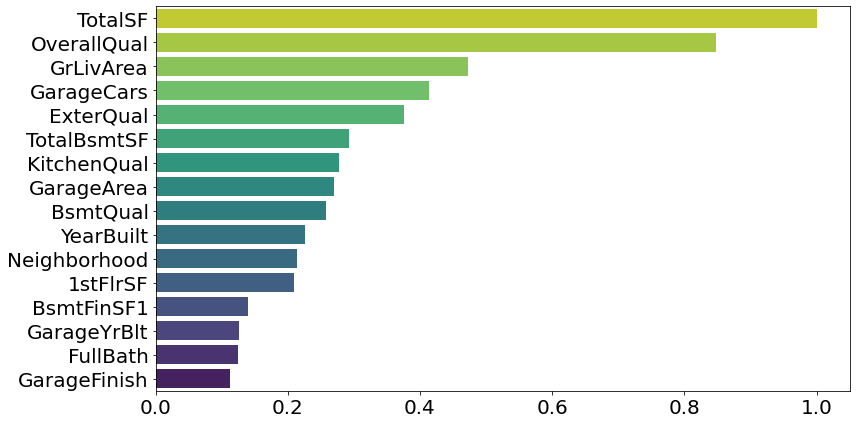

In [197]:
# Fit RFR Best and plot
RFR_best = RandomForestRegressor(random_state=rng, **RFR_best_params)
RFR_best.fit(X_tree, y_train)

# Create plot data
plot_data = pd.DataFrame(zip(features, RFR_best.feature_importances_),
             columns = ['Feature', 'Importance'])
plot_data = plot_data.sort_values(by = 'Importance', ascending = False)
plot_data['Importance'] = plot_data['Importance'].values / plot_data['Importance'].values.max()

# Plot importance at least 0.1
f, ax = plt.subplots(figsize = (12,6))
sns.barplot(data=plot_data.loc[plot_data.Importance>=0.1], 
            y='Feature', 
            x='Importance',
            palette='viridis_r')
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=20)
f.tight_layout()

In [198]:
# Store best features
best_features = dict()
best_features['RFR'] = plot_data.loc[plot_data.Importance>=0.1].Feature.values

# Gradient Boosting Regressor

In [199]:
# Gradient Boosting Regressor function
def GBR_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'learning_rate' : params['learning_rate'],
              'max_depth' : int(params['max_depth']),
              'min_samples_leaf' : int(params['min_samples_leaf']),
              'max_features' : int(params['max_features']),}
    
    model = GradientBoostingRegressor(random_state=rng, loss='huber', **params)
        
    score = np.mean(cv_rmse(model, X_tree, y_train))
    
    return score

In [200]:
# Hyperparameter tuning
space = {'n_estimators' : hp.quniform('n_estimators', low=2500, high=5000, q=250),
         'learning_rate' : hp.uniform('learning_rate', low=0.04, high=0.06),
         'min_samples_leaf' : hp.quniform('min_samples_leaf', low=5, high=10, q=1),
         'max_depth' : hp.quniform('max_depth', low=1, high=10, q=1),
         'max_features' : hp.quniform('max_features', low=4, high=9, q=1),}

trials = Trials()
GBR_best_params = fmin(
    fn = GBR_fn,
    space = space,
    algo = tpe.suggest,
    max_evals = 25*5,
    trials = trials,
    rstate = rng
)

param_list = ['n_estimators', 
              'max_depth',
              'min_samples_leaf',
              'max_features']
for param in param_list:
    GBR_best_params[param] = int(GBR_best_params[param])
    
pickle.dump(GBR_best_params, open("../output/GBR.pkl", "wb"))
GBR_best_params

100%|██████████| 125/125 [31:49<00:00, 15.28s/trial, best loss: 0.11288140881503246]


{'learning_rate': 0.05453327072250309,
 'max_depth': 2,
 'max_features': 7,
 'min_samples_leaf': 7,
 'n_estimators': 2750}

In [201]:
# Final score
GBR_best_params = pickle.load(open("../output/GBR.pkl", "rb"))
GBR_fn(GBR_best_params)

0.11563476999725213

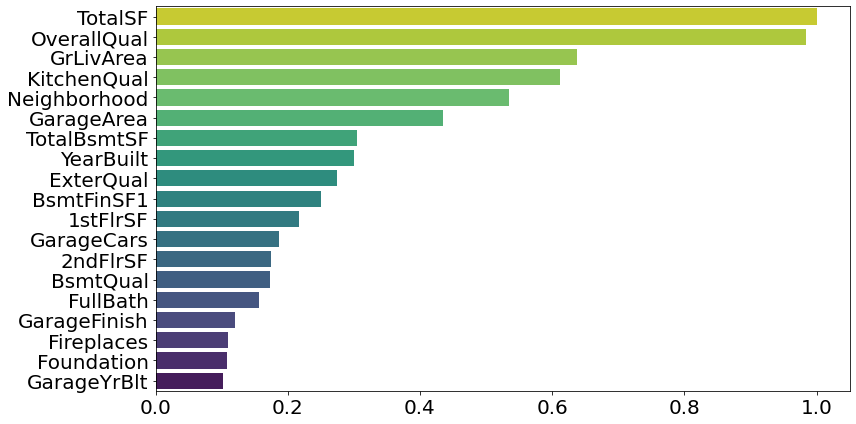

In [202]:
# Fit GBR Best and plot
GBR_best = GradientBoostingRegressor(random_state=rng, **GBR_best_params)
GBR_best.fit(X_tree, y_train)

# Create plot data
plot_data = pd.DataFrame(zip(features, GBR_best.feature_importances_),
             columns = ['Feature', 'Importance'])
plot_data = plot_data.sort_values(by = 'Importance', ascending = False)
plot_data['Importance'] = plot_data['Importance'].values / plot_data['Importance'].values.max()

# Plot importance coefficient at least 0.1
f, ax = plt.subplots(figsize = (12,6))
sns.barplot(data=plot_data.loc[plot_data.Importance>=0.1], 
            y='Feature', 
            x='Importance',
            palette='viridis_r')
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=20)
f.tight_layout()

In [203]:
# Store best features
best_features['GBR'] = plot_data.loc[plot_data.Importance>=0.1].Feature.values

# LightGBM

In [204]:
# Light Gradient Boosted Machine function
def LGBM_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'learning_rate' : params['learning_rate'],
              'max_depth' : int(params['max_depth']),
              'min_child_samples' : int(params['min_child_samples']),
              'num_leaves' : int(params['num_leaves']),
              'max_bin' : int(params['max_bin']),
              'subsample_freq' : int(params['subsample_freq']),
              'subsample' : params['subsample'],
              'reg_alpha' : params['reg_alpha'],
              'reg_lambda' : params['reg_lambda'],}
    
    model = LGBMRegressor(random_state=rng, **params)
        
    score = np.mean(cv_rmse(model, X_tree, y_train))
    
    return score

In [205]:
# Hyperparameter tuning
space = {'n_estimators' : hp.quniform('n_estimators', low=2000, high=3000, q=250),
         'learning_rate' : hp.uniform('learning_rate', low=0.005, high=0.1),
         'max_depth' : hp.quniform('max_depth', low=3, high=10, q=1),
         'min_child_samples' : hp.quniform('min_child_samples', low=1, high=5, q=1),
         'num_leaves' : hp.quniform('num_leaves', low=10, high=30, q=2),
         'max_bin' : hp.quniform('max_bin', low=20, high=400, q=20),
         'subsample_freq' : hp.quniform('subsample_freq', low=5, high=10, q=1),
         'subsample' : hp.uniform('subsample', low=0.5, high=0.7),
         'reg_alpha' : hp.uniform('reg_alpha', low=0.2, high=0.4),
         'reg_lambda' : hp.uniform('reg_lambda', low=0.4, high=0.6),}

trials = Trials()
LGBM_best_params = fmin(
    fn = LGBM_fn,
    space = space,
    algo = tpe.suggest,
    max_evals = 25*5,
    trials = trials,
    rstate = rng
)

param_list = ['n_estimators', 
              'max_depth',
              'min_child_samples',
              'num_leaves',
              'max_bin',
              'subsample_freq']
for param in param_list:
    LGBM_best_params[param] = int(LGBM_best_params[param])
    
pickle.dump(LGBM_best_params, open("../output/LGBM.pkl", "wb"))
LGBM_best_params

100%|██████████| 125/125 [06:30<00:00,  3.12s/trial, best loss: 0.1149325680700258]


{'learning_rate': 0.012820527299066478,
 'max_bin': 280,
 'max_depth': 5,
 'min_child_samples': 2,
 'n_estimators': 2250,
 'num_leaves': 16,
 'reg_alpha': 0.3179136607598297,
 'reg_lambda': 0.47753358714904615,
 'subsample': 0.5018277440994974,
 'subsample_freq': 7}

In [206]:
LGBM_best_params = pickle.load(open("../output/LGBM.pkl", "rb"))
LGBM_fn(LGBM_best_params)

0.11910297357707196

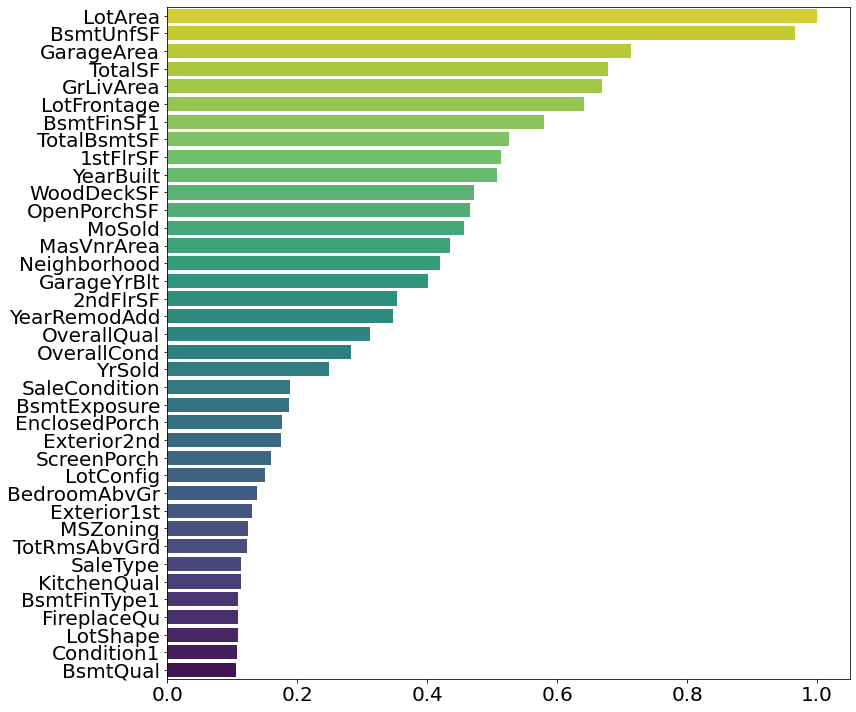

In [207]:
# Fit LGBM Best and plot
LGBM_best = LGBMRegressor(random_state=rng, **LGBM_best_params)
LGBM_best.fit(X_tree, y_train)

# Create plot data
plot_data = pd.DataFrame(zip(features, LGBM_best.feature_importances_),
             columns = ['Feature', 'Importance'])
plot_data = plot_data.sort_values(by = 'Importance', ascending = False)
plot_data['Importance'] = plot_data['Importance'].values / plot_data['Importance'].values.max()

# Plot importance coefficient at least 0.1
f, ax = plt.subplots(figsize = (12,10))
sns.barplot(data=plot_data.loc[plot_data.Importance>=0.1], 
            y='Feature', 
            x='Importance',
            palette='viridis_r')
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=20)
f.tight_layout()

In [208]:
# Store best features
best_features['LGBM'] = plot_data.loc[plot_data.Importance>=0.1].Feature.values

# XGB Rgressor

In [209]:
# Extreme Gradient Boosting function
def XGBR_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'max_depth' : int(params['max_depth']),
              'learning_rate' : params['learning_rate'],
              'min_child_weight':int(params['min_child_weight']),
              'subsample':params['subsample'],
              'colsample_bytree':params['colsample_bytree'],
              'reg_alpha':params['reg_alpha'],
              'reg_lambda':params['reg_lambda'],}
    
    model = XGBRegressor(random_state=rng, **params)
        
    score = np.mean(cv_rmse(model, X_tree, y_train))

    return score

In [210]:
# Hyperparameter tuning
space = {'n_estimators' : hp.quniform('n_estimators', low=3500, high=5000, q=250),
         'learning_rate': hp.uniform('learning_rate', low=0.03, high=0.07),
         'max_depth' : hp.quniform('max_depth', low=3, high=10, q=1),
         'min_child_weight':hp.quniform('min_child_weight', low=0, high=6, q=1),
         'subsample':hp.uniform('subsample', low=0.3, high=0.7),
         'colsample_bytree':hp.uniform('colsample_bytree', low=0.05, high=0.5),
         'reg_alpha':hp.uniform('reg_alpha', low=0, high=0.2),
         'reg_lambda':hp.uniform('reg_lambda', low=0.5, high=0.7),}

trials = Trials()
XGBR_best_params = fmin(
    fn = XGBR_fn,
    space = space,
    algo = tpe.suggest,
    max_evals = 25*5,
    trials = trials,
    rstate = rng
)

param_list = ['n_estimators', 
              'max_depth',
              'min_child_weight']
for param in param_list:
    XGBR_best_params[param] = int(XGBR_best_params[param])
    
pickle.dump(XGBR_best_params, open("../output/XGBR.pkl", "wb"))
XGBR_best_params

100%|██████████| 125/125 [15:57<00:00,  7.66s/trial, best loss: 0.11226832403241868]


{'colsample_bytree': 0.23984398333090248,
 'learning_rate': 0.0313425177126292,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 4000,
 'reg_alpha': 0.16107618377903343,
 'reg_lambda': 0.6305536428218508,
 'subsample': 0.569031402917817}

In [211]:
XGBR_best_params = pickle.load(open("../output/XGBR.pkl", "rb"))
XGBR_fn(XGBR_best_params)

0.11265493961810173

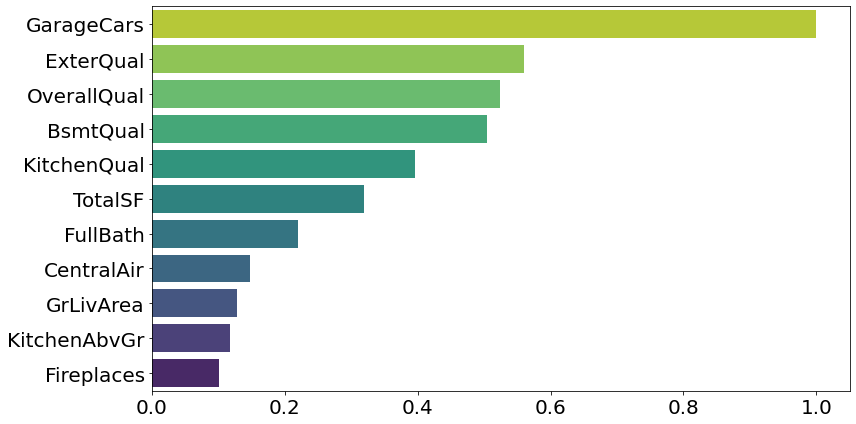

In [212]:
# Fit XGBR Best and plot
XGBR_best = XGBRegressor(random_state=rng, **XGBR_best_params)
XGBR_best.fit(X_tree, y_train)

# Create plot data
plot_data = pd.DataFrame(zip(features, XGBR_best.feature_importances_),
             columns = ['Feature', 'Importance'])
plot_data = plot_data.sort_values(by = 'Importance', ascending = False)
plot_data['Importance'] = plot_data['Importance'].values / plot_data['Importance'].values.max()

# Plot importance coefficient at least 0.1
f, ax = plt.subplots(figsize = (12,6))
sns.barplot(data=plot_data.loc[plot_data.Importance>=0.1], 
            y='Feature', 
            x='Importance',
            palette='viridis_r')
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=20)
f.tight_layout()

In [213]:
# Store best features
best_features['XGBR'] = plot_data.loc[plot_data.Importance>=0.1].Feature.values

# Remove Less Important Features
- Removal of less important features can reduce variance and improve MSE
- Test XGBoost with a restricted feature set where I drop any features with less than 10% max feature importance in all of the models
- Can we beat a CV MSE of 0.1127?

In [ ]:
keep_features = list()
for best_feature in best_features.values():
    keep_features = keep_features + list(best_feature)
    
keep_features = list(set(keep_features))
keep_features

In [239]:
# Restricted Feature Data Set
X_tree_res = pd.DataFrame(X_tree, columns = features)
X_tree_res = X_tree_res[keep_features]

# Extreme Gradient Boosting function
def XGBR_res_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'max_depth' : int(params['max_depth']),
              'learning_rate' : params['learning_rate'],
              'min_child_weight':int(params['min_child_weight']),
              'subsample':params['subsample'],
              'colsample_bytree':params['colsample_bytree'],
              'reg_alpha':params['reg_alpha'],
              'reg_lambda':params['reg_lambda'],}
    
    model = XGBRegressor(random_state=rng, **params)
        
    score = np.mean(cv_rmse(model, X_tree_res, y_train))

    return score

In [240]:
# Hyperparameter tuning
space = {'n_estimators' : hp.quniform('n_estimators', low=3500, high=5000, q=250),
         'learning_rate': hp.uniform('learning_rate', low=0.03, high=0.07),
         'max_depth' : hp.quniform('max_depth', low=3, high=10, q=1),
         'min_child_weight':hp.quniform('min_child_weight', low=0, high=6, q=1),
         'subsample':hp.uniform('subsample', low=0.3, high=0.7),
         'colsample_bytree':hp.uniform('colsample_bytree', low=0.05, high=0.5),
         'reg_alpha':hp.uniform('reg_alpha', low=0, high=0.2),
         'reg_lambda':hp.uniform('reg_lambda', low=0.5, high=0.7),}

trials = Trials()
XGBR_res_best_params = fmin(
    fn = XGBR_res_fn,
    space = space,
    algo = tpe.suggest,
    max_evals = 25*5,
    trials = trials,
    rstate = rng
)

param_list = ['n_estimators', 
              'max_depth',
              'min_child_weight']
for param in param_list:
    XGBR_res_best_params[param] = int(XGBR_res_best_params[param])
    
pickle.dump(XGBR_res_best_params, open("../output/XGBR_res.pkl", "wb"))
XGBR_res_best_params

100%|██████████| 125/125 [14:30<00:00,  6.96s/trial, best loss: 0.1140142912926619]


{'colsample_bytree': 0.24506614637280377,
 'learning_rate': 0.03289935105786148,
 'max_depth': 3,
 'min_child_weight': 0,
 'n_estimators': 4250,
 'reg_alpha': 0.08573482479542367,
 'reg_lambda': 0.6015030325402423,
 'subsample': 0.47961424230319794}

CV MSE is very similar to 0.1127. No improvement.

In [243]:
XGBR_res_best_params = pickle.load(open("../output/XGBR_res.pkl", "rb"))
XGBR_res_fn(XGBR_res_best_params)

0.11639264350940517

# Meta-Learn 1: Stacked Regressor

In [244]:
# Stacking Regressor function
def Stacking_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'max_depth' : int(params['max_depth']),
              'learning_rate' : params['learning_rate'],
              'min_child_weight':int(params['min_child_weight']),
              'subsample':params['subsample'],
              'colsample_bytree':params['colsample_bytree'],
              'reg_alpha':params['reg_alpha'],
              'reg_lambda':params['reg_lambda'],}
    
    estimators = [
        ('RFR', RFR_best),
        ('GBR', GBR_best),
        ('LGBM', LGBM_best),
        ('XGBR', XGBR_best),
    ]

    model = StackingRegressor(
        estimators = estimators,
        final_estimator = XGBRegressor(random_state = rng, **params),
        cv = kfolds,
        passthrough = True,
    )
        
    score = np.mean(cv_rmse(model, X_tree, y_train))
    
    return score

In [245]:
# Hyperparameter tuning
space = {'n_estimators' : hp.quniform('n_estimators', low=2000, high=4000, q=250),
         'learning_rate': hp.uniform('learning_rate', low=0.01, high=0.05),
         'max_depth' : hp.quniform('max_depth', low=3, high=10, q=1),
         'min_child_weight' : hp.quniform('min_child_weight', low=0, high=6, q=1),
         'subsample' : hp.uniform('subsample', low=0.4, high=0.6),
         'colsample_bytree' : hp.uniform('colsample_bytree', low=0.2, high=0.5),
         'reg_alpha' : hp.uniform('reg_alpha', low=0, high=0.2),
         'reg_lambda' : hp.uniform('reg_lambda', low=0.5, high=0.8),}

trials = Trials()
Stacking_best_params = fmin(
    fn = Stacking_fn,
    space = space,
    algo = tpe.suggest,
    max_evals = 25*5,
    trials = trials,
    rstate = rng
)

param_list = ['n_estimators', 
              'max_depth',
              'min_child_weight']
for param in param_list:
    Stacking_best_params[param] = int(Stacking_best_params[param])
    
pickle.dump(Stacking_best_params, open("../output/Stacking.pkl", "wb"))
Stacking_best_params

 82%|████████▏ | 103/125 [2:14:30<27:41, 75.53s/trial, best loss: 0.11077217379539409] 

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



100%|██████████| 125/125 [2:42:42<00:00, 78.10s/trial, best loss: 0.11077217379539409]


{'colsample_bytree': 0.299142736613601,
 'learning_rate': 0.044401479060130256,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 2500,
 'reg_alpha': 0.014940600973787844,
 'reg_lambda': 0.7333110182388825,
 'subsample': 0.49861364171386946}

In [246]:
Stacking_best_params = pickle.load(open("../output/Stacking.pkl", "rb"))
Stacking_fn(Stacking_best_params)

0.1170993543108679

In [247]:
estimators = [
    ('RFR', RFR_best),
    ('GBR', GBR_best),
    ('LGBM', LGBM_best),
    ('XGBR', XGBR_best),
]
Stacking_best = StackingRegressor(
    estimators = estimators,
    final_estimator = XGBRegressor(random_state = rng, **Stacking_best_params),
    cv = kfolds,
    passthrough = True,
)

#  Meta Learner 2: Voting Regressor (Weighted Average)

In [220]:
estimators = [('RFR_best', RFR_best), 
              ('GBR_best', GBR_best),
              ('LGBM_best', LGBM_best),
              ('XGBR_best', XGBR_best)]

# Calculate weights
weights = []
for estimator in estimators:
    score = estimator[1].score(X_tree, y_train)
    weights.append(score)
    
weights = weights/np.sum(weights)
assert round(np.sum(weights),4)==1
    
# Voting 
VotingRegressor_best = VotingRegressor(estimators, weights=weights, n_jobs=64)

In [221]:
# CV RMSE
np.mean(cv_rmse(VotingRegressor_best, X_tree, y_train))

0.11431220803387983

# Calculate Dollar Difference

In [222]:
# Dollar difference helper function
def get_dollar_difference(model, X, y):
    model.fit(X,y)
    y_predict = model.predict(X)
    return mean_absolute_error(y, y_predict)

models = {'RFR_best' : RFR_best, 
          'GBR_best' : GBR_best,
          'XGBR_best' : XGBR_best,
          'LBGM_best': LGBM_best,
          'Stacking_best' : Stacking_best,
          'VotingRegressor_best' : VotingRegressor_best}

results = {}
for name, model in models.items():
    results[name] = get_dollar_difference(model, X_tree, y_train)
    
results_table = pd.DataFrame(results.values(), index=results.keys(), columns = ['Results'])
results_table.sort_values(by='Results')

,Results
XGBR_best,702.535951
LBGM_best,3560.326606
Stacking_best,4292.188411
VotingRegressor_best,5249.963470
GBR_best,6548.599509
RFR_best,12934.723466
